# **貓狗影像分類**

## **連結Google帳戶的雲端硬碟**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **複製雲端中的影像資料至Colab本機中**

In [ ]:
! cp "/content/drive/My Drive/Dataset/dogs-vs-cats/sampleSubmission.csv" /content/
! cp "/content/drive/My Drive/Dataset/dogs-vs-cats/test1.zip" /content/
! cp "/content/drive/My Drive/Dataset/dogs-vs-cats/train.zip" /content/

## **解壓縮檔案**

In [ ]:
#解壓
! unzip /content/test1.zip > data_unzip.log
! unzip /content/train.zip > data_unzip.log

## **建立影像資料集**
* 定義資料集的大小與維度
* 將影像存至空陣列中，以建立特徵與標籤

In [ ]:
import os
import numpy as np

#影像的輸入大小
im_W = 100
im_H = 100

#影像的輸入維度
datachannel = 3

#影像的path
class_path = r"/content/train"

#影像該位置的所有檔案名稱
class_filenames = os.listdir(class_path)

#建立空陣列並定義大小，將給予輸入存取的空間：根據影像數量與輸入大小及維度
data_1d = np.empty((len(class_filenames), im_W*im_H*datachannel), dtype="uint8")
data_2d = np.empty((len(class_filenames), im_W,im_H, datachannel), dtype="uint8")

#建立皆為0且檔案數量的label
label = [0] * len(class_filenames)

In [ ]:
from PIL import Image

#塞制空陣列的輸入與label
for i in range(len(class_filenames)):
    
    #label根據檔案名字前一個字，取代之前建利皆為0的label
    if(class_filenames[i][0] == 'c'):
        label[i] = 0
    if(class_filenames[i][0] == 'd'):
        label[i] = 1
    
    #每一影像讀取
    img = Image.open(class_path + "/" + class_filenames[i])
    
    #每一影像改變大小
    reimg = img.resize((im_W,im_H,))
    
    #將該影像轉成陣列
    npimg_2d = np.asarray(reimg, dtype="uint8")
    npimg_1d = npimg_2d.flatten()
    
    #持續將影像陣列蓋掉之前空陣列
    data_1d[i,:] = npimg_1d
    data_2d[i,:,:,:] = npimg_2d

In [ ]:
from keras.utils import to_categorical
from collections import Counter

#打印出影像的維度與標籤的維度
print("影像1d的維度：", data_1d.shape)
print("影像2d的維度：", data_2d.shape)
print("標籤的維度：", len(label)) 

#打印出訓練集的每個類別數量
print("訓練集標籤數量：%s" %(len(label)))
print("訓練集標籤的類別數量：",Counter(label))

#將Label轉為One-hot-encode
label_ohe = to_categorical(label)

print("原始標籤：", label[0])
print("獨熱編碼標籤：", label_ohe[0])

Using TensorFlow backend.


影像1d的維度： (25000, 30000)
影像2d的維度： (25000, 100, 100, 3)
標籤的維度： 25000
訓練集標籤數量：25000
訓練集標籤的類別數量： Counter({0: 12500, 1: 12500})
原始標籤： 0
獨熱編碼標籤： [1. 0.]


## **正規化處理**

In [ ]:
#正規化處理
non_data_1d = data_1d.astype('float32')/255
non_data_2d = data_2d.astype('float32')/255

## **顯示影像**
* 單張顯示
* 批量顯示

(100, 100, 3)
0


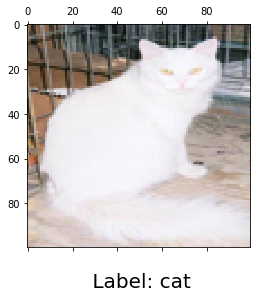

In [ ]:
import matplotlib.pyplot as plt

feature_name = ['cat', 'dog'] 

first_label = label[0]
first_img = data_1d[0].reshape(100,100,3)
#first_img = data_2d[0]
first_label_name = feature_name[first_label]

print(first_img.shape)
print(first_label)

plt.matshow(first_img)
plt.xlabel("\n Label: %s" %(first_label_name), size=20)
plt.show()

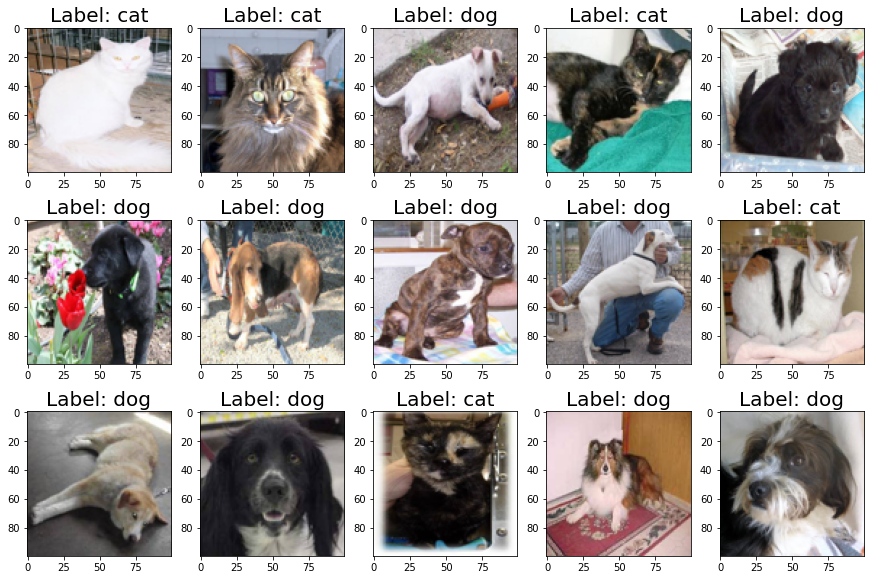

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(15):
  ax = plt.subplot(3,5, 1+i)
  ax.imshow(data_2d[i]) 
  ax.set_title("Label: %s" %(feature_name[label[i]]), size=20)
plt.show()

# **多層感知器：建立模型**
* 建立序列式模型
* 輸入層(Input Layer)
* 隱藏層(Hidden Layer)
* 激勵函數 (Activation Function)
* 輸出層 (Output Layer)：sofmax, sigmoid

In [ ]:
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(1000, input_shape=(100*100*3,), activation="relu"))
model.add(Dense(500, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              30001000  
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 30,551,701
Trainable params: 30,551,701
Non-trainable params: 0
_________________________________________________________________


## **指定訓練集評量方式來編譯模型**
* 損失函數 (Loss function)
* 優化器 (Optimizer)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])

## **訓練模型**
* 小批量(Mini-batch)
* 分割驗證集(Validation Set)

In [ ]:
history = model.fit(x=non_data_1d, y=label, batch_size=100, epochs=300, validation_split= 0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/300
22500/22500 [==============================] - 119s 5ms/step - loss: 1.0918 - acc: 0.5455 - val_loss: 0.6626 - val_acc: 0.6016
Epoch 2/300
22500/22500 [==============================] - 118s 5ms/step - loss: 0.6731 - acc: 0.5894 - val_loss: 0.6529 - val_acc: 0.6088
Epoch 3/300
22500/22500 [==============================] - 119s 5ms/step - loss: 0.6557 - acc: 0.6095 - val_loss: 0.6624 - val_acc: 0.5932
Epoch 4/300
22500/22500 [==============================] - 118s 5ms/step - loss: 0.6484 - acc: 0.6194 - val_loss: 0.6434 - val_acc: 0.6240
Epoch 5/300
22500/22500 [==============================] - 117s 5ms/step - loss: 0.6431 - acc: 0.6248 - val_loss: 0.6479 - val_acc: 0.6104
Epoch 6/300
22500/22500 [==============================] - 118s 5ms/step - loss: 0.6374 - acc: 0.6329 - val_loss: 0.6640 - val_acc: 0.6020
Epoch 7/300
22500/22500 [==============================] - 118s 5ms/step - loss: 0.6334 - acc: 0.6386 - val_loss: 0.6

## **儲存模型與權重**

In [ ]:
from keras.models import load_model

#儲存模型
model.save('mlp_dog_vs_cat.h5')

#載入模型
from tensorflow.keras.models import load_model

model = load_model('mlp_dog_vs_cat.h5')

# **卷積神經網路：建立模型**
* 建立序列式模型
* 卷積層 (Convolution Layer)
* 激勵函數 (Activation Function)
* 填充 (Padding)
* 丟棄法 (Dropout)
* 池化層 (Pooling Layer)
* 全連接層 (Fully Connected Layer)
* 輸出層 (Output Layer)：sofmax, sigmoid

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

cnn = Sequential()
cnn.add(Conv2D(32,(4,4),activation='relu', padding='same', input_shape=(100,100,3)))

cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Conv2D(64,(4,4),activation='relu', padding='same'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Flatten())
cnn.add(Dropout(0.2))

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(2, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      1568      
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

## **指定訓練集評量方式來編譯模型**
* 損失函數 (Loss function)
* 優化器 (Optimizer)

In [ ]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

## **訓練模型**
* 小批量(Mini-batch)
* 分割驗證集(Validation Set)

In [ ]:
history = cnn.fit(x=non_data_2d, y=label_ohe, batch_size=100, epochs=20, validation_split= 0.1)

Epoch 1/20
225/225 [==============================] - 538s 2s/step - loss: 0.6981 - acc: 0.6026 - val_loss: 0.6125 - val_acc: 0.6660
Epoch 2/20
225/225 [==============================] - 539s 2s/step - loss: 0.5566 - acc: 0.7178 - val_loss: 0.5342 - val_acc: 0.7536
Epoch 3/20
225/225 [==============================] - 538s 2s/step - loss: 0.4959 - acc: 0.7582 - val_loss: 0.4876 - val_acc: 0.7784
Epoch 4/20
225/225 [==============================] - 539s 2s/step - loss: 0.4418 - acc: 0.7937 - val_loss: 0.4951 - val_acc: 0.7688
Epoch 5/20
225/225 [==============================] - 539s 2s/step - loss: 0.3992 - acc: 0.8199 - val_loss: 0.4488 - val_acc: 0.8000
Epoch 6/20
225/225 [==============================] - 540s 2s/step - loss: 0.3571 - acc: 0.8428 - val_loss: 0.4511 - val_acc: 0.8000
Epoch 7/20
225/225 [==============================] - 546s 2s/step - loss: 0.3140 - acc: 0.8638 - val_loss: 0.4190 - val_acc: 0.8092
Epoch 8/20
225/225 [==============================] - 547s 2s/step - 

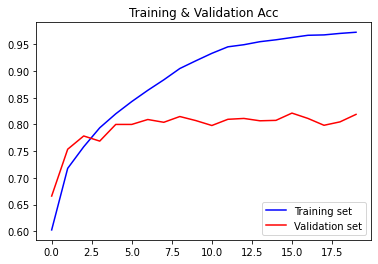

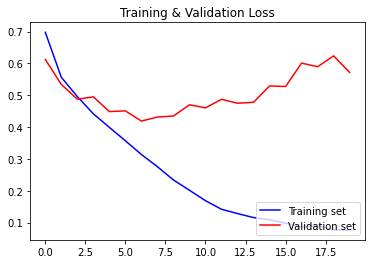

In [ ]:
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title("Training & Validation Acc")
plt.plot(np.arange(len(acc)), acc,color='b', label="Training set")
plt.plot(np.arange(len(val_acc)), val_acc,color='r', label="Validation set")
plt.legend(loc='lower right')
plt.show()

plt.title("Training & Validation Loss")
plt.plot(np.arange(len(loss)), loss,color='b', label="Training set")
plt.plot(np.arange(len(val_loss)), val_loss,color='r', label="Validation set")
plt.legend(loc='lower right')
plt.show()

訓練集的準確度為：0.9803
訓練集的損失值為：0.0767


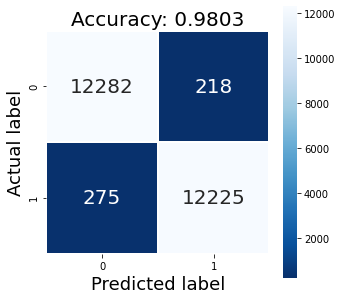

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

train_loss, train_acc = cnn.evaluate(non_data_2d, label_ohe)
print("訓練集的準確度為：%0.4f" %(train_acc))
print("訓練集的損失值為：%0.4f" %(train_loss))

predict = cnn.predict(non_data_2d)
predictions = [np.argmax(one_hot)for one_hot in predict]

cm = confusion_matrix(label, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1.0, square = True, cmap = 'Blues_r',annot_kws={"size": 20});
plt.ylabel('Actual label', size = 18);
plt.xlabel('Predicted label', size = 18);
plt.title('Accuracy: %0.4f' %(train_acc), size = 20);

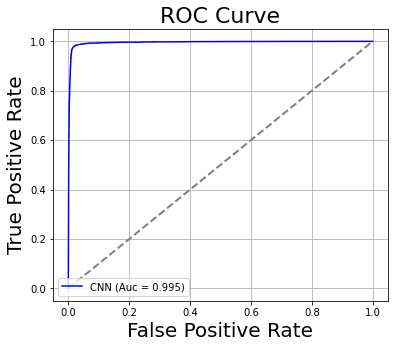

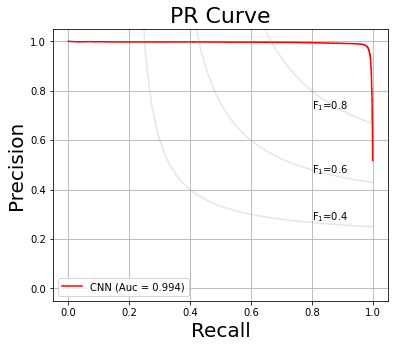

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

#繪製ROC曲線
fpr, tpr, thresholds = roc_curve(y_true=label, y_score=predict[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='b', label='%s (Auc = %0.3f)' % ('CNN', roc_auc))
plt.legend(loc='lower left')
plt.title("ROC Curve", size = 22)
plt.plot([0, 1],[0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate', size = 20)
plt.ylabel('True Positive Rate', size = 20)
plt.show()

#繪製PR曲線
precision, recall, thresholds = precision_recall_curve(label, predict[:,1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall,precision,color='r',label='%s (Auc = %0.3f)' % ('CNN', pr_auc))
plt.legend(loc='lower left')
plt.title("PR Curve" ,size = 22)

f_scores = np.linspace(0.4, 0.8, num=3)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('F$_1$={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02)) 
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('Recall',size =20)
plt.ylabel('Precision',size =20)
plt.show()

## 儲存模型與權重

In [ ]:
from keras.models import load_model

#儲存模型
cnn.save('cnn_dog_vs_cat.h5')

#載入模型
from tensorflow.keras.models import load_model

cnn = load_model('cnn_dog_vs_cat.h5')

## **測試模型**
* 多張影像預測

In [ ]:
#測試集影像的path
class_path = r"/content/test1"

#影像該位置的所有檔案名稱
class_filenames = os.listdir(class_path)

#建立空陣列並定義大小，將給予輸入存取的空間：根據影像數量與輸入大小及維度
test_2d = np.empty((len(class_filenames), im_W,im_H, datachannel), dtype="uint8")

#塞至空陣列的輸入與label
for i in range(len(class_filenames)):
    
    #每一影像讀取
    img = Image.open(class_path + "/" + class_filenames[i])
    
    #每一影像改變大小
    reimg = img.resize((im_W,im_H,))
    
    #將該影像轉成陣列
    npimg_2d = np.asarray(reimg, dtype="uint8")
    
    #持續將影像陣列蓋掉之前空陣列
    test_2d[i,:,:,:] = npimg_2d

#打印出影像的維度與標籤的維度
print("影像2d的維度：", test_2d.shape)

#正規化
non_test_2d = test_2d.astype('float32')/255

影像2d的維度： (12500, 100, 100, 3)


In [ ]:
predict = cnn.predict(non_test_2d)
predictions = [np.argmax(one_hot)for one_hot in predict]

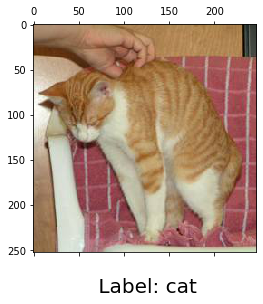

In [ ]:
num = 0

plt.matshow(Image.open(class_path + "/" + class_filenames[num]))
plt.xlabel("\n Label: %s" %(feature_name[predictions[num]]), size=20)
plt.show()

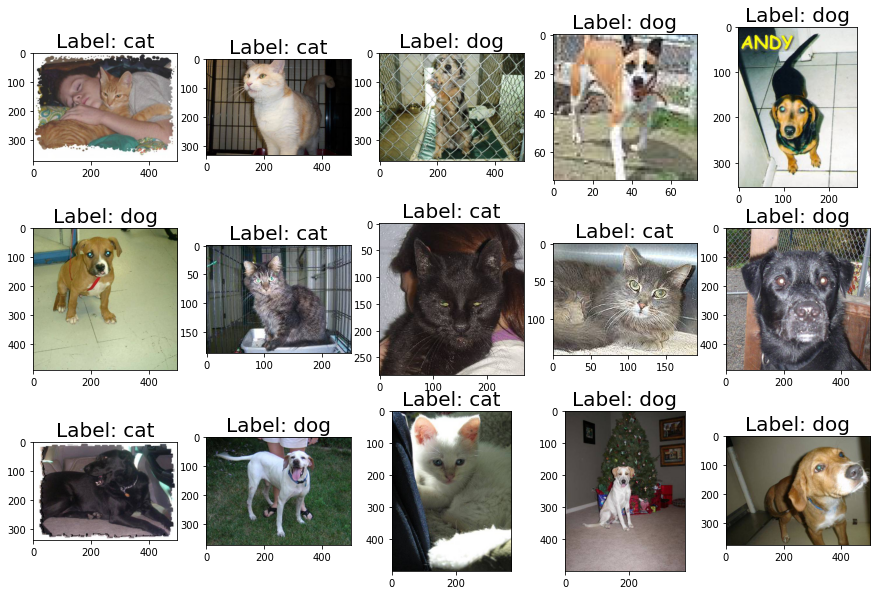

In [ ]:
num = np.arange(17,32,1)
img_num = 1

plt.figure(figsize=(15, 10))
for i in num:
  ax = plt.subplot(3,5, img_num)
  ax.imshow(Image.open(class_path + "/" + class_filenames[i])) 
  ax.set_title("Label: %s" %(feature_name[predictions[i]]), size=20)
  img_num += 1
plt.show()